# Task
We want to achieve the following workflow:

Step 1. 
- Get phonon snapshots from equilibirum dump file 
- Unfortanely, we cannot continue the dflow as multem needs GPU, will continue on a real cluster

Step 2.
- Download the phonon snapshots from MD simulations
- Do multem simulations (CBED and STEM)
- Average over phonon configurations

In [6]:
from distutils.command.upload import upload
from deepmdem.multem import PreparePhonon
from dflow import Step, Workflow, download_artifact, upload_artifact
from dflow.python import (OP, OPIO, Artifact, OPIOSign, PythonOPTemplate,
                          upload_packages)
from typing import List
from pathlib import Path

upload_packages.append('../deepmdem/')

step0 = Step(
    name="PreparePhonon",
    template=PythonOPTemplate(PreparePhonon, 
    image="dreamleadsz/pymultem:cuda11.3_gpu",image_pull_policy="IfNotPresent"),
    parameters={
        "nphonon": 30,
        "skip_frame": 10,
    },
    artifacts={"lammps_dump": upload_artifact(Path("bulk_Al/equilibrium_bulk_deepmd_273K.dump"))},
)
from dflow import Workflow
wf = Workflow(name="multem")
wf.add(step0)
wf.submit();

Workflow has been submitted (ID: multem-pl2tt)


In [2]:
# Same as above OP but just use phonon 
import dpdata
system = dpdata.System('bulk_Al/equilibrium_slab_deepmd_273K.dump', fmt = 'lammps/dump',type_map=['Mg','Al'],unwrap=True)
nphonon=30
skip_frame=10
import numpy as np
idx_list = np.linspace(
    skip_frame, len(system) - 1,nphonon, dtype=int
)
file_list = []
for idx in idx_list:
    file = f"bulk_Al/out_art/snap_{idx}.lammps"
    file_list.append(file)
    system.to_lammps_lmp(file, frame_idx=idx)

GPU available: True
Time: 0.41
GPU available: True
Time: 0.19
GPU available: True
Time: 0.19
GPU available: True
Time: 0.19
GPU available: True
Time: 0.19
GPU available: True
Time: 0.19
GPU available: True
Time: 0.20
GPU available: True
Time: 0.19
GPU available: True
Time: 0.19
GPU available: True
Time: 0.18


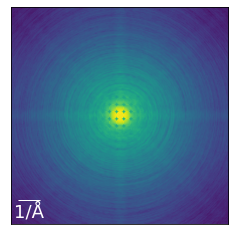

In [1]:
from deepmdem.multem import run_MULTEM
import glob
import numpy as np
import matplotlib.pyplot as plt
from deepmdem.multem import plot_image

snapshots= glob.glob('bulk_Al/out_art/*.lammps')
dat_list = []
for snapshot in snapshots:
    dat,pixel_size=run_MULTEM(atoms_conf=snapshot,energy=100,convergence_angle=10,simulation_type='CBED',max_scattering_vector=5,type_map={0:12,1:13},bwl=False)
    dat_list.append(dat[-1])
    # break
cbed_avg = np.abs(sum(dat_list))/len(dat_list)

plot_image(np.log(cbed_avg),pixel_size=pixel_size,space="reciprocal")


GPU available: True
Time: 22.43
GPU available: True
Time: 22.45
GPU available: True
Time: 21.77
GPU available: True
Time: 21.34
GPU available: True
Time: 21.40
GPU available: True
Time: 21.37
GPU available: True
Time: 21.98
GPU available: True
Time: 21.21
GPU available: True
Time: 22.01
GPU available: True
Time: 21.42


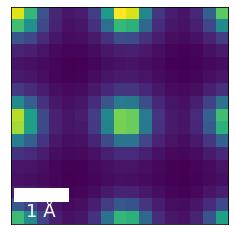

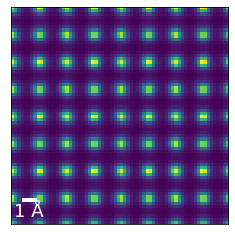

In [2]:
from dataclasses import dataclass
from deepmdem.multem import run_MULTEM
import glob
import numpy as np
import matplotlib.pyplot as plt
snapshots= glob.glob('bulk_Al/out_art/*.lammps')
dat_list = []
tile = (4,4)
for snapshot in snapshots:
    dat,pixel_size=run_MULTEM(atoms_conf=snapshot,energy=300,convergence_angle=20,simulation_type='STEM',collection_angle=[(50,200)],type_map={0:12,1:13},scanning_area=[3/8,3/8,4/8,4/8])
    dat_list.append(dat[-1])
stem_avg = np.abs(np.sum(dat_list,axis=0))/len(dat_list)

from deepmdem.multem import plot_image
plot_image(stem_avg[0],pixel_size=pixel_size) 
plot_image(stem_avg[0],pixel_size=pixel_size,tile=tile) 
np.save(file='stem_md.npy',arr=stem_avg)